In [49]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import math
import json
import re

hf = "/home"
sys.path.append(hf+"/will/projects/legoproj")
sys.path.append(hf+"/will/projects/training/dataprep")

import feature_utils as fu
from cvscripts import cv_utils as cvu

%matplotlib inline

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)

import keras
from keras.models import load_model


def getObjFromHue(hue,dset):
    hue = int(round(hue/5))
    name = dset["ids"][str(hue)]
    return name


def getObjectsData(dset):
    
    objsdata = {}
    for entry in dset["ids"]:

        if entry == "0":
            continue

        name = dset["ids"][entry]
        objentry = dset["objects"][name]

        #print(objentry)

        l2w = fu.matrix_from_string(objentry["modelmat"])
        w2l = np.linalg.inv(l2w)

        bbl = np.array(objentry["bbl"])
        bbh = np.array(objentry["bbh"])

        dims = bbh - bbl

        info = {}
        info["w2l"] = w2l
        info["lows"] = bbl

        info["dims"] = dims
        info["name"] = dset["ids"][entry]

        objsdata[name] = info
        
    return objsdata

In [62]:
datapath = "/home/will/projects/legoproj/data/kpts_dset_5/"
data = fu.dictFromJson(datapath + "dset.json")
i = 65
tag = "{:0>4}".format(i)
maskpath = datapath + "{}_masks.png".format(tag)

mask = cv2.imread(maskpath)
masks = cvu.separate(mask)

for hue in masks:
    objname = getObjFromHue(hue,data)
    if objname:
        objclass = objname.split(".")[0]
        if objclass == "WingL":
            wing = objname
            break
            

studs = fu.get_object_studs(objclass)
for stud in studs:
    stud.append(1.0)
    
projmat = fu.matrix_from_string(data["projection"])
modelmat = fu.matrix_from_string(data["objects"][objname]["modelmat"])
viewmat = fu.matrix_from_string(data["viewmats"][i])

screenverts = fu.verts_to_screen(modelmat, viewmat, projmat, studs, filter=False)
screenverts[:,0:2] = fu.toNDC(screenverts[:,0:2], (512,512))

overts = np.array(studs, dtype=np.float32)[:,0:3]
overts[:,2] = 0.0
sverts = np.array(screenverts, dtype=np.float32)[:,1::-1]
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([overts.astype('float32')], [sverts.astype('float32')], (512,512), None, None)

print(mtx)
 
mtx =  np.array([[576.25736016,  0.,  248.52187883],[  0., 574.53464108, 245.49564339],[  0., 0., 1.  ]])
 
#[[576.25736016   0.         248.52187883]
# [  0.         574.53464108 245.49564339]
# [  0.           0.           1.        ]]

[[115.43931053   0.         260.3208998 ]
 [  0.         169.84693761 256.80723529]
 [  0.           0.           1.        ]]


In [63]:
model = load_model("/home/will/projects/legoproj/nets/tstgeom_poleeng_bayes_fr.h5",compile=False)

In [73]:
i = 82
tag = "{:0>4}".format(i)

img = cv2.imread(datapath + "{}_a.png".format(tag),0)        
img = cv2.resize(img,(256,256),interpolation=cv2.INTER_LINEAR)
geomraw = cv2.imread(datapath + "geom/{}_geom.png".format(tag))

pred = model.predict( np.reshape(img, (1,256,256,1)).astype('float32')/255.0 )
pred = (255.0 * np.reshape((1.0+pred)/2.0, (256,256,4))).astype(np.uint8)

geom_pred = pred[:,:,0:3].astype(np.uint8)
confidence = (255 - np.reshape( pred[:,:,3:], (256,256) )).astype(np.uint8)


names = []

maskpath = datapath + "{}_masks.png".format(tag)

mask = cv2.imread(maskpath)
masks = cvu.separate(mask)

for hue in masks:
    objname = getObjFromHue(hue,data)
    #print(objname)
    if objname:
        objclass = objname.split(".")[0]
        if objclass and objclass == "Pole":# or objclass == "Pole"):
            names.append(tuple([objname,hue]))
            
rows = np.arange(256)
cols = np.arange(256)

r,c = np.meshgrid(rows,cols)
inds = np.stack((r,c),axis=-1).astype(np.uint8)

objsdata = getObjectsData(data)

    
for obj in names:
    
    name, hue = obj[0], obj[1]

    
    dims = objsdata[name]["dims"]
    bbl = objsdata[name]["lows"]
    
    print(dims.shape)
    
    objmask = masks[hue]
    
    print(name)
    
    objmask = cv2.resize(objmask, (256,256), cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (256,256), cv2.INTER_LINEAR)
    geom_pred = cv2.resize(geom_pred, (256,256), cv2.INTER_LINEAR)
    confidence = cv2.resize(confidence, (256,256), cv2.INTER_LINEAR)
    
    region = cv2.bitwise_and(geom_pred,geom_pred,mask=objmask)
    conf = cv2.bitwise_and(confidence,confidence,mask=objmask)
    
    thresh = conf > 240
    
    coords = (bbl + dims * (region[thresh]/255))#[:,2::-1]
    
    locs = 2 * inds[thresh][:,1::-1]
        
    print(locs)
    print(coords)

    #break

(3,)
Pole.004
[[214 100]
 [214 102]
 [214 104]
 ...
 [246 112]
 [246 114]
 [246 116]]
[[ 0.12486274  0.14933335 -0.27858824]
 [ 0.12988235  0.15937257 -0.26804706]
 [ 0.13239215  0.18949022 -0.26101961]
 ...
 [ 0.05333333 -2.22996079  0.0306196 ]
 [ 0.04454902 -2.21992158  0.03589019]
 [ 0.0345098  -2.21992158  0.03764705]]
(3,)
Pole.001
[[ 48 202]
 [ 48 204]
 [ 48 206]
 ...
 [250  26]
 [250  28]
 [250  30]]
[[ 0.12109804  0.2396863  -0.26277647]
 [ 0.12737255  0.2396863  -0.26453334]
 [ 0.13113725  0.24972551 -0.26453334]
 ...
 [ 0.03701961 -1.44690196 -0.10465883]
 [ 0.03576471 -1.46698039 -0.09763138]
 [ 0.0294902  -1.50713726 -0.0870902 ]]


In [76]:
#ret, rvec, tvec,inliers = cv2.solvePnPRansac(coords.astype(np.float32), locs.astype(np.float32), mtx,None,flags=cv2.SOLVEPNP_EPNP,reprojectionError=3,iterationsCount=100)
ret, rvec, tvec,inliers = cv2.solvePnPRansac(coords.astype(np.float32), locs.astype(np.float32), mtx, dist, flags=(cv2.SOLVEPNP_ITERATIVE))


True
in
[[  19]
 [  31]
 [  32]
 ...
 [1818]
 [1829]
 [1840]]
(18, 135)
(19, 296)
(185, 280)


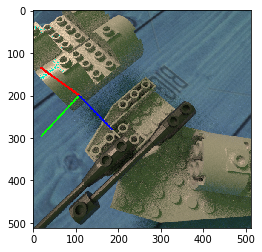

'\nrvec = r[1]\ntvec = r[2]\ntvec\n'

In [77]:
(pt, jac) = cv2.projectPoints(np.array([(0,0.0,0.0),(1.0, 0.0, 0.0),(0.0, 1.0, 0.0),(0.0, 0.0, 1.0)]), rvec, tvec, mtx, dist)
pt = pt.astype(int)

img3 = cv2.imread(datapath + "{}_a.png".format(tag))        

print(ret)
print("in")
print(inliers)


lines = [(255,0,0), (0,255,0), (0,0,255)]


i = 0
for point in pt[1:4]:
    o = pt[0][0]
    print(tuple(point[0]))
    cv2.line(img3, tuple(o), tuple(point[0]), lines[i], 3)
    i+=1
    
plt.imshow(img3)
plt.show()

'''
rvec = r[1]
tvec = r[2]
tvec
'''